In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('/content/full_red_spider_count.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [4]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [5]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


# EDA

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os # To check if file exists

# --- Configuration ---
original_data_file = '/content/full_red_spider_count.csv' # <<< --- Verified this is your filename
target_total_rows = 10000 # Aim for about 27 years total (adjust as needed)
default_start_date_original = '1998-01-01' # <<< --- Default start if no date found

# --- Step 1: Load Your Original Data ---
try:
    # Load your data
    df_original = pd.read_csv(original_data_file)
    print(f"Successfully loaded original data from: {original_data_file}")
    print(f"Original data shape (before index): {df_original.shape}")

    # --- Data Cleaning/Preparation for Original Data ---

    # Attempt to find and set a DatetimeIndex
    date_col_found = False
    date_col_options = ['Date', 'date', 'Timestamp', 'timestamp'] # Common date column names

    # Option 1: Check for common date column names
    for col in date_col_options:
        if col in df_original.columns:
            try:
                print(f"Found potential date column: '{col}'. Attempting conversion...")
                df_original[col] = pd.to_datetime(df_original[col])
                df_original = df_original.set_index(col)
                date_col_found = True
                print(f"Successfully set '{col}' as DatetimeIndex.")
                break # Stop after finding the first valid date column
            except Exception as e:
                print(f"Warning: Could not convert column '{col}' to datetime. Error: {e}")
                # Reset index if set_index failed partially
                if col in df_original.index.name:
                    df_original = df_original.reset_index()

    # Option 2: If no column found, check if index is ALREADY datetime
    if not date_col_found and isinstance(df_original.index, pd.DatetimeIndex):
        print("DataFrame already has a DatetimeIndex.")
        date_col_found = True # Mark as found

    # Option 3: Check if the *first* column might be an unnamed date index
    if not date_col_found and df_original.columns[0].lower() in ['unnamed: 0', 'index']:
        try:
            print("Attempting to use the first column as DatetimeIndex...")
            # Use the first column's values to create the index
            potential_dates = pd.to_datetime(df_original.iloc[:, 0])
            df_original.index = potential_dates
            # Drop the original index column now that it's the index
            df_original = df_original.drop(columns=df_original.columns[0])
            date_col_found = True
            print("Successfully used the first column as DatetimeIndex.")
        except Exception as e:
            print(f"Warning: Could not convert the first column ('{df_original.columns[0]}') to DatetimeIndex. Error: {e}")

    # Option 4: If still no date index, ASSIGN ONE assuming consecutive daily data
    if not date_col_found:
        print("\nWarning: No suitable Date column or index found in the original data.")
        print(f"Assuming consecutive daily readings starting from '{default_start_date_original}'.")
        num_original_rows = len(df_original)
        generated_dates = pd.date_range(start=default_start_date_original, periods=num_original_rows, freq='D')
        df_original.index = generated_dates
        print(f"Assigned a DatetimeIndex from {generated_dates.min().strftime('%Y-%m-%d')} to {generated_dates.max().strftime('%Y-%m-%d')}.")
        date_col_found = True # Mark as "found" because we assigned it


    # If after all attempts, we still don't have a DatetimeIndex, exit.
    if not isinstance(df_original.index, pd.DatetimeIndex):
         print("\nError: Failed to establish a DatetimeIndex for the original data. Cannot proceed.")
         exit()

    # Ensure essential columns exist (add placeholders if missing, adjust as needed)
    required_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
    for col in required_cols:
        if col not in df_original.columns:
            print(f"Warning: Column '{col}' not found in original data. Adding placeholder (NaN or default).")
            if col == 'label':
                 df_original[col] = 'unknown' # Or 'rice' if you know it's all rice
            else:
                 df_original[col] = np.nan # Add NaN, consider imputation later if needed

    # Select only the required columns in a consistent order
    # (handle potential KeyError if a required col was missing AND placeholder wasn't added - though unlikely with above loop)
    try:
        df_original = df_original[required_cols]
    except KeyError as e:
        print(f"Error selecting required columns: {e}. Check if placeholder logic worked.")
        exit()

    # Sort by date (essential!)
    df_original = df_original.sort_index()

    print(f"\nOriginal data shape (after index set/assignment): {df_original.shape}")
    print("Original data head (with DatetimeIndex):")
    print(df_original.head())
    print("Original data tail (with DatetimeIndex):")
    print(df_original.tail())

    original_rows = len(df_original)
    last_original_date = df_original.index.max() # <<< --- This should now work
    start_synthetic_date = last_original_date + pd.Timedelta(days=1)
    print(f"\nLast date in original data: {last_original_date.strftime('%Y-%m-%d')}")
    print(f"Start date for synthetic data: {start_synthetic_date.strftime('%Y-%m-%d')}")


except FileNotFoundError:
    print(f"Error: The file '{original_data_file}' was not found.")
    print("Please make sure the file exists in the same directory or provide the full path.")
    # Set defaults to allow script to run for demonstration if file is missing
    df_original = pd.DataFrame() # Empty dataframe
    original_rows = 0
    start_synthetic_date = pd.to_datetime('2024-01-01') # Default start if no original data
    print("Proceeding with generating only synthetic data.")
except Exception as e:
    print(f"\nAn unexpected error occurred during original data loading/processing: {e}")
    print("Cannot proceed.")
    exit()


# --- Step 2: Generate Additional Synthetic Data ---
# (Code remains the same as previous correct version, EXCEPT for .to_numpy())
rows_to_generate = max(0, target_total_rows - original_rows)

if rows_to_generate > 0:
    print(f"\nGenerating {rows_to_generate} additional rows of synthetic data...")

    synthetic_dates = pd.date_range(start=start_synthetic_date, periods=rows_to_generate, freq='D')
    synthetic_day_of_year = synthetic_dates.dayofyear.to_numpy() # Convert Index to NumPy array

    # Temperature
    temp_base = 22; temp_amplitude = 8
    synth_temperature = temp_base + temp_amplitude * np.sin((synthetic_day_of_year - 90) * 2 * np.pi / 365) + np.random.normal(0, 2, rows_to_generate)
    synth_temperature = np.clip(synth_temperature, 5, 38)

    # Humidity
    humidity_base = 75; humidity_amplitude = 10
    synth_humidity = humidity_base - humidity_amplitude * np.sin((synthetic_day_of_year - 120) * 2 * np.pi / 365) + np.random.normal(0, 5, rows_to_generate)

    synth_humidity -= (synth_temperature - synth_temperature.mean()) * 0.5
    synth_humidity = np.clip(synth_humidity, 30, 98)

    # Rainfall (rest of generation code is the same...)
    rain_chance = 0.15
    synth_rainfall = np.zeros(rows_to_generate)
    rain_indices = np.random.rand(rows_to_generate) < rain_chance
    rain_amounts = np.random.exponential(scale=8.0, size=rows_to_generate)
    synth_rainfall[rain_indices] = rain_amounts[rain_indices]
    synth_rainfall[synth_rainfall < 1] = 0
    synth_rainfall = np.clip(synth_rainfall, 0, 200)

    # Other features (using averages/random noise)
    N_mean = df_original['N'].mean() if original_rows > 0 and not df_original['N'].isnull().all() else 75
    P_mean = df_original['P'].mean() if original_rows > 0 and not df_original['P'].isnull().all() else 45
    K_mean = df_original['K'].mean() if original_rows > 0 and not df_original['K'].isnull().all() else 42
    ph_mean = df_original['ph'].mean() if original_rows > 0 and not df_original['ph'].isnull().all() else 7.0

    synth_N = np.clip(np.random.normal(N_mean, 10, rows_to_generate).astype(int), 10, 150)
    synth_P = np.clip(np.random.normal(P_mean, 8, rows_to_generate).astype(int), 10, 100)
    synth_K = np.clip(np.random.normal(K_mean, 5, rows_to_generate).astype(int), 10, 80)
    synth_ph = np.clip(np.random.normal(ph_mean, 0.5, rows_to_generate), 4.0, 9.0)
    synth_label = ['rice'] * rows_to_generate

    df_synthetic = pd.DataFrame({
        'N': synth_N, 'P': synth_P, 'K': synth_K, 'temperature': synth_temperature,
        'humidity': synth_humidity, 'ph': synth_ph, 'rainfall': synth_rainfall,
        'label': synth_label
    }, index=synthetic_dates)
    print(f"Synthetic data generated. Shape: {df_synthetic.shape}")
else:
    print("\nOriginal data already meets or exceeds target row count. No synthetic data generated.")
    df_synthetic = pd.DataFrame()

# ... (Rest of the script Step 3 onwards remains the same) ...


# --- Step 3: Combine Original and Synthetic Data ---
# (Code remains the same as previous correct version)
if not df_synthetic.empty:
    df_combined = pd.concat([df_original, df_synthetic], axis=0)
    df_combined = df_combined.sort_index()
    print(f"\nCombined original and synthetic data. Total shape: {df_combined.shape}")
else:
    df_combined = df_original.copy()
    print("\nUsing only original data.")

# Handle NaNs (e.g., from missing original columns)
if df_combined.isnull().any().any():
    print("\nWarning: Found NaNs in combined data. Performing forward/backward fill.")
    df_combined.fillna(method='ffill', inplace=True)
    df_combined.fillna(method='bfill', inplace=True)
    if df_combined.isnull().any().any():
         print("Warning: NaNs still persist. Filling remaining numeric with mean, object with 'unknown'.")
         for col in df_combined.columns:
             if df_combined[col].isnull().any():
                 if pd.api.types.is_numeric_dtype(df_combined[col]):
                     df_combined[col].fillna(df_combined[col].mean(), inplace=True)
                 else:
                     df_combined[col].fillna('unknown', inplace=True)


# --- Step 4: Run RSM Simulation on COMBINED Data ---
# (Code remains the same as previous correct version)
print("\nRunning Red Spider Mite simulation on the combined dataset...")
df_combined['Red_spider_mite_count'] = 0.0
df_combined['Red_spider_mite_category'] = 'Low'

initial_count = 10.0; temp_high_thresh = 30.0; temp_med_thresh = 25.0; temp_low_thresh = 15.0
humid_low_thresh = 50.0; humid_med_thresh = 60.0; humid_high_thresh = 80.0
rain_high_thresh = 10.0; rain_med_thresh = 5.0; sensitivity_divisor = 7.0
max_random_addition = 5; base_survival = 0.98
heavy_rain_wash_factor = 0.6; moderate_rain_wash_factor = 0.9

if len(df_combined) > 0:
    df_combined.iloc[0, df_combined.columns.get_loc('Red_spider_mite_count')] = initial_count

for i in range(1, len(df_combined)):
    previous_count = df_combined.iloc[i-1]['Red_spider_mite_count']
    temp = df_combined.iloc[i]['temperature']; humid = df_combined.iloc[i]['humidity']; rain = df_combined.iloc[i]['rainfall']
    change_factor = 0.0
    if temp > temp_high_thresh: change_factor += 1.8
    elif temp > temp_med_thresh: change_factor += 1.2
    elif temp < temp_low_thresh: change_factor -= 0.8
    if humid < humid_low_thresh: change_factor += 1.2
    elif humid < humid_med_thresh: change_factor += 0.6
    elif humid > humid_high_thresh: change_factor -= 1.0
    growth_rate = 1.0 + (change_factor / sensitivity_divisor)
    potential_new_count = previous_count * max(base_survival, growth_rate) + np.random.randint(0, max_random_addition + 1)
    if rain > rain_high_thresh: potential_new_count *= heavy_rain_wash_factor
    elif rain > rain_med_thresh: potential_new_count *= moderate_rain_wash_factor
    new_count = max(0.0, potential_new_count)
    df_combined.iloc[i, df_combined.columns.get_loc('Red_spider_mite_count')] = new_count

df_combined['Red_spider_mite_count'] = df_combined['Red_spider_mite_count'].round().astype(int)

def assign_category(count):
    if count <= 10: return 'Low'
    elif count <= 50: return 'Medium'
    elif count <= 150: return 'High'
    else: return 'Severe'
df_combined['Red_spider_mite_category'] = df_combined['Red_spider_mite_count'].apply(assign_category)

print("RSM Simulation complete.")
print("\nCheck value distribution in COMBINED data:")
print("Category Distribution:"); print(df_combined['Red_spider_mite_category'].value_counts())
print("\nCount Statistics:"); print(df_combined['Red_spider_mite_count'].describe())


# --- Step 5: Feature Engineering (Lags, Rolling, Date) on COMBINED Data ---
# (Code remains the same as previous correct version)
print("\nApplying feature engineering...")
lags_to_create = [1, 3, 7]; target_and_drivers = ['Red_spider_mite_count', 'temperature', 'humidity', 'rainfall']
for feature in target_and_drivers:
    for lag in lags_to_create: df_combined[f'{feature}_lag_{lag}'] = df_combined[feature].shift(lag)

window_sizes = [3, 7, 14]
for window in window_sizes:
    df_combined[f'count_roll_mean_{window}'] = df_combined['Red_spider_mite_count'].rolling(window=window, min_periods=1).mean()
    df_combined[f'count_roll_max_{window}'] = df_combined['Red_spider_mite_count'].rolling(window=window, min_periods=1).max()
    df_combined[f'count_roll_std_{window}'] = df_combined['Red_spider_mite_count'].rolling(window=window, min_periods=1).std().fillna(0)

features_to_roll = ['temperature', 'humidity', 'rainfall']
for feature in features_to_roll:
    for window in window_sizes:
        df_combined[f'{feature}_roll_mean_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).mean()
        if feature == 'temperature':
            df_combined[f'{feature}_roll_max_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).max()
            df_combined[f'{feature}_roll_min_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).min()
        if feature == 'humidity':
            df_combined[f'{feature}_roll_min_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).min()
            df_combined[f'{feature}_roll_max_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).max()
        if feature == 'rainfall':
            df_combined[f'{feature}_roll_sum_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).sum()

df_combined['month'] = df_combined.index.month; df_combined['day_of_year'] = df_combined.index.dayofyear
df_combined['day_of_week'] = df_combined.index.dayofweek; df_combined['week_of_year'] = df_combined.index.isocalendar().week.astype(int)
print("Feature engineering complete.")


# --- Step 6: Handle Missing Values from Feature Engineering ---
# (Code remains the same as previous correct version)
original_combined_rows = len(df_combined)
final_df = df_combined.dropna()
removed_rows = original_combined_rows - len(final_df)

print(f"\nOriginal combined rows: {original_combined_rows}")
print(f"Number of rows after dropping NaNs from lags/rolling: {len(final_df)}")
print(f"Removed {removed_rows} rows from the beginning.")
print("\nFinal Cleaned DataFrame head:"); print(final_df.head())
print("\nFinal Cleaned DataFrame Info:"); final_df.info()


# --- Optional: Save the final feature-engineered data ---
# final_output_file = 'final_feature_engineered_mite_data.csv'
# final_df.to_csv(final_output_file)
# print(f"\nFinal feature-engineered data saved to {final_output_file}")

# --- Ready for Model Training ---
print("\nDataset is now ready for Step 3 (Data Splitting) and Step 4 (Model Training).")

Successfully loaded original data from: /content/full_red_spider_count.csv
Original data shape (before index): (2200, 8)

Assuming consecutive daily readings starting from '1998-01-01'.
Assigned a DatetimeIndex from 1998-01-01 to 2004-01-09.

Original data shape (after index set/assignment): (2200, 8)
Original data head (with DatetimeIndex):
             N   P   K  temperature   humidity        ph    rainfall label
1998-01-01  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1998-01-02  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
1998-01-03  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
1998-01-04  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
1998-01-05  78  42  42    20.130175  81.604873  7.628473  262.717340  rice
Original data tail (with DatetimeIndex):
              N   P   K  temperature   humidity        ph    rainfall   label
2004-01-05  107  34  32    26.774637  66.413269  6.780064  177.774507  coffee
2004-01-0

In [20]:
final_df['Red_spider_mite_category'].value_counts()

,count
Red_spider_mite_category,
Low,9076
Severe,801
Medium,64
High,52


# Another way

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# --- Configuration ---
original_data_file = '/content/full_red_spider_count.csv'
target_total_rows = 10000
default_start_date_original = '1998-01-01'
output_file = 'red_spider_mite_forecast_data.csv'
random_seed = 42  # For reproducibility
np.random.seed(random_seed)

# --- Step 1: Load Original Data ---
try:
    df_original = pd.read_csv(original_data_file)
    print(f"Successfully loaded original data from: {original_data_file}")
    print(f"Original data shape (before index): {df_original.shape}")

    date_col_found = False
    date_col_options = ['Date', 'date', 'Timestamp', 'timestamp']
    for col in date_col_options:
        if col in df_original.columns:
            try:
                df_original[col] = pd.to_datetime(df_original[col])
                df_original = df_original.set_index(col)
                date_col_found = True
                print(f"Successfully set '{col}' as DatetimeIndex.")
                break
            except Exception as e:
                print(f"Warning: Could not convert column '{col}' to datetime. Error: {e}")

    if not date_col_found:
        print("\nWarning: No suitable Date column found. Assuming daily readings from '1998-01-01'.")
        num_original_rows = len(df_original)
        generated_dates = pd.date_range(start=default_start_date_original, periods=num_original_rows, freq='D')
        df_original.index = generated_dates
        print(f"Assigned DatetimeIndex from {generated_dates.min().strftime('%Y-%m-%d')} to {generated_dates.max().strftime('%Y-%m-%d')}.")

    required_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
    for col in required_cols:
        if col not in df_original.columns:
            print(f"Warning: Column '{col}' not found. Adding placeholder.")
            if col == 'label':
                df_original[col] = 'unknown'
            elif col in ['N', 'P', 'K']:
                df_original[col] = np.random.normal(50, 20, len(df_original)).astype(int)
            elif col == 'temperature':
                df_original[col] = np.random.normal(25, 5, len(df_original))
            elif col == 'humidity':
                df_original[col] = np.random.normal(70, 10, len(df_original))
            elif col == 'ph':
                df_original[col] = np.random.normal(6.5, 0.5, len(df_original))
            elif col == 'rainfall':
                df_original[col] = np.random.exponential(scale=5.0, size=len(df_original))
            else:
                df_original[col] = np.nan

    # Ensure we only keep the required columns
    df_original = df_original[required_cols]
    df_original = df_original.sort_index()

    if df_original.isnull().any().any():
        print("\nWarning: NaNs in original data. Filling with ffill/bfill.")
        df_original.fillna(method='ffill', inplace=True)
        df_original.fillna(method='bfill', inplace=True)
        for col in df_original.columns:
            if df_original[col].isnull().any():
                df_original[col].fillna(df_original[col].mean() if pd.api.types.is_numeric_dtype(df_original[col]) else 'unknown', inplace=True)

    original_rows = len(df_original)
    last_original_date = df_original.index.max()
    start_synthetic_date = last_original_date + pd.Timedelta(days=1)
    print(f"\nLast date in original data: {last_original_date.strftime('%Y-%m-%d')}")
    print(f"Start date for synthetic data: {start_synthetic_date.strftime('%Y-%m-%d')}")

except FileNotFoundError:
    print(f"Error: File '{original_data_file}' not found. Generating synthetic data only.")
    required_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
    df_original = pd.DataFrame(columns=required_cols)
    original_rows = 0
    start_synthetic_date = pd.to_datetime(default_start_date_original)

# --- Step 2: Generate Synthetic Data ---
rows_to_generate = max(0, target_total_rows - original_rows)
if rows_to_generate > 0:
    print(f"\nGenerating {rows_to_generate} synthetic rows...")
    synthetic_dates = pd.date_range(start=start_synthetic_date, periods=rows_to_generate, freq='D')
    synthetic_day_of_year = synthetic_dates.dayofyear.to_numpy()
    synthetic_year = synthetic_dates.year.to_numpy() - synthetic_dates.year.min() + 1
    
    # Add long-term climate trends (slight warming over time)
    year_effect = (synthetic_year - 1) * 0.03  # 0.03°C increase per year

    # Temperature - More realistic seasonal pattern with some year-to-year variability
    temp_base = 25 
    temp_amplitude = 10
    seasonal_effect = np.sin((synthetic_day_of_year - 90) * 2 * np.pi / 365)
    
    # Add El Niño/La Niña-like multi-year oscillations (3-5 year cycle)
    years = synthetic_dates.year.to_numpy()
    multi_year_cycle = np.sin((years - years.min()) * 2 * np.pi / 4)  # ~4 year cycle
    
    synth_temperature = (
        temp_base + 
        temp_amplitude * seasonal_effect + 
        year_effect +  # Long-term warming
        multi_year_cycle * 1.5 +  # Multi-year climate oscillations
        np.random.normal(0, 2.0, rows_to_generate)  # Daily variation
    )
    synth_temperature = np.clip(synth_temperature, 8, 45)  # Allow slightly higher extremes

    # Humidity - Inversely related to temperature but with some independent variation
    humidity_base = 70
    humidity_amplitude = 15
    synth_humidity = (
        humidity_base - 
        humidity_amplitude * seasonal_effect + 
        np.random.normal(0, 7, rows_to_generate) -
        (synth_temperature - synth_temperature.mean()) * 0.5  # Higher temps -> lower humidity
    )
    synth_humidity = np.clip(synth_humidity, 20, 99)

    # Rainfall - More realistic with seasonal patterns, dry spells, and occasional extreme events
    # Create baseline seasonal rainfall pattern
    rain_seasonal = 0.2 + 0.3 * np.sin((synthetic_day_of_year - 150) * 2 * np.pi / 365)
    
    # Generate random binary rain events (more likely in wet seasons)
    rain_chance = rain_seasonal + 0.05 * multi_year_cycle  # Climate cycles affect rainfall probability
    rain_indices = np.random.rand(rows_to_generate) < rain_chance
    
    # Create rain amounts for those days (exponential distribution)
    rain_scale = 8.0 + 4.0 * rain_seasonal  # Heavier rain in wet seasons
    rain_amounts = np.random.exponential(scale=rain_scale, size=rows_to_generate)
    
    # Create occasional extreme events (about 1% of rainy days)
    extreme_indices = (np.random.rand(rows_to_generate) < 0.01) & rain_indices
    rain_amounts[extreme_indices] *= np.random.uniform(3, 8, size=extreme_indices.sum())
    
    synth_rainfall = np.zeros(rows_to_generate)
    synth_rainfall[rain_indices] = rain_amounts[rain_indices]
    synth_rainfall = np.clip(synth_rainfall, 0, 300)  # Allow more extreme rainfall events

    # Add dry spells (autocorrelation in rainfall)
    rain_binary = (synth_rainfall > 0).astype(int)
    for i in range(1, len(rain_binary)):
        # 80% chance dry day follows dry day
        if rain_binary[i-1] == 0 and np.random.rand() < 0.8:
            rain_binary[i] = 0
    
    synth_rainfall = synth_rainfall * rain_binary

    # Other features with some correlation to environmental conditions
    N_base = df_original['N'].mean() if original_rows > 0 else 50
    P_base = df_original['P'].mean() if original_rows > 0 else 53
    K_base = df_original['K'].mean() if original_rows > 0 else 48
    ph_base = df_original['ph'].mean() if original_rows > 0 else 6.5
    
    # Create correlations with rainfall and temperature
    synth_N = N_base - 5 * np.sin(synthetic_day_of_year * 2 * np.pi / 365) + synth_rainfall * 0.1
    synth_P = P_base + 3 * np.sin((synthetic_day_of_year + 60) * 2 * np.pi / 365) - synth_rainfall * 0.05
    synth_K = K_base + 4 * np.sin((synthetic_day_of_year + 120) * 2 * np.pi / 365)
    synth_ph = ph_base - 0.3 * np.sin(synthetic_day_of_year * 2 * np.pi / 365) - synth_rainfall * 0.005
    
    # Add noise and ensure values are in reasonable ranges
    synth_N = np.clip(synth_N + np.random.normal(0, 15, rows_to_generate), 5, 140).astype(int)
    synth_P = np.clip(synth_P + np.random.normal(0, 12, rows_to_generate), 5, 145).astype(int)
    synth_K = np.clip(synth_K + np.random.normal(0, 18, rows_to_generate), 5, 205).astype(int)
    synth_ph = np.clip(synth_ph + np.random.normal(0, 0.4, rows_to_generate), 3.5, 9.5)

    # Label - use original if available, otherwise use synthetic crop type
    if original_rows > 0 and df_original['label'].nunique() == 1:
        synth_label_value = df_original['label'].iloc[0]
    else:
        # Assign a mix of crop types
        crop_types = ['tomato', 'bean', 'cucumber', 'strawberry', 'rose']
        crop_probs = [0.3, 0.2, 0.2, 0.15, 0.15]
        synth_label = np.random.choice(crop_types, size=rows_to_generate, p=crop_probs)

    df_synthetic = pd.DataFrame({
        'N': synth_N, 
        'P': synth_P, 
        'K': synth_K, 
        'temperature': synth_temperature,
        'humidity': synth_humidity, 
        'ph': synth_ph, 
        'rainfall': synth_rainfall,
        'label': synth_label if 'synth_label' in locals() else [synth_label_value] * rows_to_generate
    }, index=synthetic_dates)
    
    print(f"Synthetic data generated. Shape: {df_synthetic.shape}")
else:
    df_synthetic = pd.DataFrame()

# --- Step 3: Combine Data ---
df_combined = pd.concat([df_original, df_synthetic], axis=0).sort_index()
print(f"\nCombined data shape: {df_combined.shape}")

if df_combined.isnull().any().any():
    print("\nWarning: NaNs in combined data. Filling with ffill/bfill.")
    df_combined.fillna(method='ffill', inplace=True)
    df_combined.fillna(method='bfill', inplace=True)

# --- Step 4: Red Spider Mite Simulation with Enhanced Dynamics ---
print("\nRunning enhanced Red Spider Mite simulation...")

# Configuration parameters
initial_count = 10.0
temp_low = 15.0
temp_opt_low = 25.0 
temp_opt_high = 35.0
temp_high = 40.0  # Increased slightly to allow more extreme values
humid_low = 35.0  # Slightly lower threshold for favorable conditions
humid_med = 60.0
humid_high = 70.0
humid_extreme = 90.0
rain_med = 5.0
rain_high = 10.0
base_survival = 0.97  # Slightly increased baseline survival
sensitivity_divisor = 18.0  # Adjusted for potentially higher growth rates
MAX_MITES_PER_LEAF = 600  # Increased to allow more severe infestations

# Add predator pressure (natural enemies)
predator_base = 0.08  # Base predation rate
predator_seasonal = 0.04  # Seasonal variation in predation
predator_response_lag = 14  # Days for predator populations to respond to prey density

# Add pesticide application and resistance dynamics
pesticide_effect_duration = 14  # Days pesticide remains effective
pesticide_resistance_rate = 0.005  # Rate at which resistance develops

# Simulate regular pesticide applications when mite counts exceed threshold
pesticide_threshold = 100
pesticide_effectiveness = 0.85  # Initial kill rate
pesticide_decay_rate = 0.1  # Daily decay in effectiveness
resistance_level = 0.0  # Starts at zero, builds over time

# Add columns to track biological factors
df_combined['Red_spider_mite_count'] = 0.0
df_combined['Red_spider_mite_category'] = 'Low'
df_combined['Pesticide_active'] = 0
df_combined['Resistance_level'] = 0.0
df_combined['Predation_pressure'] = 0.0

# Initialize first day
df_combined.iloc[0, df_combined.columns.get_loc('Red_spider_mite_count')] = initial_count
df_combined.iloc[0, df_combined.columns.get_loc('Predation_pressure')] = predator_base

# Create some occasional outbreaks
# Select random points (about 5-10) to inject "outbreak seeds"
outbreak_points = np.random.choice(range(100, len(df_combined)-1000), 
                                    size=np.random.randint(5, 10), 
                                    replace=False)

# Create some management intervention points
intervention_points = []

# Run simulation
days_since_treatment = 999  # Start with no recent treatment
for i in range(1, len(df_combined)):
    previous_count = df_combined.iloc[i-1]['Red_spider_mite_count']
    temp = df_combined.iloc[i]['temperature']
    humid = df_combined.iloc[i]['humidity']
    rain = df_combined.iloc[i]['rainfall']
    current_resistance = df_combined.iloc[i-1]['Resistance_level']
    
    # Update days since treatment and treatment activity
    if days_since_treatment < pesticide_effect_duration:
        days_since_treatment += 1
        df_combined.iloc[i, df_combined.columns.get_loc('Pesticide_active')] = max(0, 
            pesticide_effectiveness * (1 - days_since_treatment * pesticide_decay_rate) * (1 - current_resistance))
    else:
        df_combined.iloc[i, df_combined.columns.get_loc('Pesticide_active')] = 0
    
    # Check if we should apply pesticide (threshold exceeded or scheduled application)
    if previous_count > pesticide_threshold or i in intervention_points:
        days_since_treatment = 0
        df_combined.iloc[i, df_combined.columns.get_loc('Pesticide_active')] = pesticide_effectiveness * (1 - current_resistance)
        intervention_points.append(i)  # Record this intervention
        
        # Update resistance level (increases more when population is higher)
        new_resistance = current_resistance + pesticide_resistance_rate * (previous_count / MAX_MITES_PER_LEAF)
        df_combined.iloc[i, df_combined.columns.get_loc('Resistance_level')] = min(0.85, new_resistance)
    else:
        # Resistance slowly decreases when not exposed to pesticides
        df_combined.iloc[i, df_combined.columns.get_loc('Resistance_level')] = max(0, current_resistance - 0.001)
    
    # Calculate predation pressure (increases with mite density but lags)
    if i > predator_response_lag:
        avg_past_density = df_combined.iloc[i-predator_response_lag:i]['Red_spider_mite_count'].mean() / MAX_MITES_PER_LEAF
        seasonal_factor = 1 + predator_seasonal * np.sin((df_combined.index[i].dayofyear - 120) * 2 * np.pi / 365)
        predation = predator_base * seasonal_factor * (1 + 2 * avg_past_density)
        df_combined.iloc[i, df_combined.columns.get_loc('Predation_pressure')] = predation
    else:
        df_combined.iloc[i, df_combined.columns.get_loc('Predation_pressure')] = predator_base
    
    # Calculate environmental effects on mite population
    change_factor = 0.0
    
    # Temperature effects - bell curve response
    if temp > temp_high:
        change_factor -= 2.0 * ((temp - temp_high) / 5)  # Stronger penalty for extreme heat
    elif temp_opt_low <= temp <= temp_opt_high:
        # Optimal range with peak around 32°C
        temp_optimality = 1 - abs(temp - 32) / 7  # How close to the optimal 32°C
        change_factor += 1.8 * temp_optimality
    elif temp < temp_low:
        change_factor -= 1.2 * ((temp_low - temp) / 5)  # Stronger penalty for cold

    # Humidity effects - nonlinear response
    if humid < humid_low:
        change_factor += 1.2  # Very dry conditions favor mites
    elif humid < humid_med:
        change_factor += 0.7 * (humid_med - humid) / (humid_med - humid_low)  # Gradual effect
    elif humid > humid_extreme:
        change_factor -= 1.8  # Very wet conditions strongly suppress mites
    elif humid > humid_high:
        change_factor -= 1.0 * (humid - humid_high) / (humid_extreme - humid_high)  # Gradual effect
    
    # Inject occasional outbreak conditions (simulating migration events, etc.)
    if i in outbreak_points:
        # Inject a "seed" population and favorable conditions
        previous_count = max(previous_count, np.random.randint(30, 50))
        change_factor += np.random.uniform(1.0, 2.0)
        print(f"Outbreak seed injected at day {i} (date: {df_combined.index[i].strftime('%Y-%m-%d')})")
    
    # Growth with density dependence - modified logistic growth
    r = change_factor / sensitivity_divisor
    density_factor = 1 - (previous_count / MAX_MITES_PER_LEAF) ** 1.2  # Stronger impact at high densities
    growth_rate = 1.0 + r * density_factor
    
    # Apply survival rate, predation, and pesticide effects
    pesticide_effect = df_combined.iloc[i]['Pesticide_active']
    predation = df_combined.iloc[i]['Predation_pressure'] * previous_count / 100
    
    potential_new_count = (
        previous_count * growth_rate * base_survival -  # Base growth & survival
        predation -  # Predation (increases with mite density)
        (previous_count * pesticide_effect)  # Pesticide effect
    )
    
    # Add stochasticity - more variance at higher populations
    noise_level = max(1.0, np.sqrt(previous_count) / 3)
    noise = np.random.normal(0, noise_level)
    potential_new_count = max(0.0, potential_new_count + noise)
    
    # Rainfall wash-off effect
    if rain > rain_high:
        wash_off = 0.4 + 0.1 * min(1.0, (rain - rain_high) / 20)  # Stronger effect for extreme rain
        potential_new_count *= (1 - wash_off)
    elif rain > rain_med:
        potential_new_count *= 0.85
    
    # Ensure population stays within bounds
    new_count = max(0.1, min(potential_new_count, MAX_MITES_PER_LEAF))  # Minimum 0.1 to avoid extinction
    df_combined.iloc[i, df_combined.columns.get_loc('Red_spider_mite_count')] = new_count

# Post-processing
df_combined['Red_spider_mite_count'] = df_combined['Red_spider_mite_count'].round().astype(int)

def assign_category(count):
    if count <= 10: return 'Low'
    elif count <= 50: return 'Medium'
    elif count <= 200: return 'High'
    else: return 'Severe'

df_combined['Red_spider_mite_category'] = df_combined['Red_spider_mite_count'].apply(assign_category)

print("\nSimulation complete. Distribution:")
print(df_combined['Red_spider_mite_category'].value_counts())
print("\nMite Count Statistics:")
print(df_combined['Red_spider_mite_count'].describe())

# Plot the time series
plt.figure(figsize=(15, 8))
plt.plot(df_combined.index, df_combined['Red_spider_mite_count'])
plt.title('Red Spider Mite Population Over Time')
plt.ylabel('Count')
plt.xlabel('Date')
plt.yscale('log')  # Log scale to better visualize both low and high values
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Try to save if in a notebook environment
try:
    plt.savefig('mite_population_timeseries.png')
    print("Saved plot to mite_population_timeseries.png")
except Exception as e:
    print(f"Could not save plot: {e}")

plt.close()

# --- Step 5: Enhanced Feature Engineering ---
print("\nApplying enhanced feature engineering...")

# Basic lag features
lags = [1, 3, 7, 14, 21, 30]
features = ['Red_spider_mite_count', 'temperature', 'humidity', 'rainfall', 'Pesticide_active', 'Resistance_level']

for feature in features:
    for lag in lags:
        df_combined[f'{feature}_lag_{lag}'] = df_combined[feature].shift(lag)

# Rolling window statistics
windows = [3, 7, 14, 30, 60]
for window in windows:
    # Mite count statistics
    df_combined[f'count_roll_mean_{window}'] = df_combined['Red_spider_mite_count'].rolling(window=window, min_periods=1).mean()
    df_combined[f'count_roll_max_{window}'] = df_combined['Red_spider_mite_count'].rolling(window=window, min_periods=1).max()
    df_combined[f'count_roll_min_{window}'] = df_combined['Red_spider_mite_count'].rolling(window=window, min_periods=1).min()
    df_combined[f'count_roll_std_{window}'] = df_combined['Red_spider_mite_count'].rolling(window=window, min_periods=1).std().fillna(0)
    
    # Rate of change features
    df_combined[f'count_growth_rate_{window}'] = (
        df_combined['Red_spider_mite_count'] / (df_combined[f'count_roll_mean_{window}'].shift(1) + 0.1) - 1
    )
    
    # Environmental variables
    for feature in ['temperature', 'humidity', 'rainfall']:
        df_combined[f'{feature}_roll_mean_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).mean()
        df_combined[f'{feature}_roll_std_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).std().fillna(0)
        
        if feature == 'temperature':
            df_combined[f'{feature}_roll_max_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).max()
            df_combined[f'{feature}_roll_min_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).min()
            df_combined[f'{feature}_extrema_{window}'] = df_combined[f'{feature}_roll_max_{window}'] - df_combined[f'{feature}_roll_min_{window}']
        
        elif feature == 'humidity':
            df_combined[f'{feature}_roll_max_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).max()
            df_combined[f'{feature}_roll_min_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).min()
            
        elif feature == 'rainfall':
            df_combined[f'{feature}_roll_sum_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).sum()
            df_combined[f'{feature}_roll_max_{window}'] = df_combined[feature].rolling(window=window, min_periods=1).max()
            # Count rainy days
            df_combined[f'rainy_days_{window}'] = df_combined['rainfall'].apply(lambda x: 1 if x > 0 else 0).rolling(window=window, min_periods=1).sum()

# Calendar and seasonal features
df_combined['month'] = df_combined.index.month
df_combined['day_of_year'] = df_combined.index.dayofyear
df_combined['day_of_week'] = df_combined.index.dayofweek
df_combined['week_of_year'] = df_combined.index.isocalendar().week.astype(int)
df_combined['quarter'] = df_combined.index.quarter
df_combined['year'] = df_combined.index.year
df_combined['days_from_start'] = (df_combined.index - df_combined.index.min()).days

# Add seasonal cyclical features (sin/cos transforms preserve the cyclical nature)
df_combined['month_sin'] = np.sin(2 * np.pi * df_combined['month'] / 12)
df_combined['month_cos'] = np.cos(2 * np.pi * df_combined['month'] / 12)
df_combined['day_of_year_sin'] = np.sin(2 * np.pi * df_combined['day_of_year'] / 365.25)
df_combined['day_of_year_cos'] = np.cos(2 * np.pi * df_combined['day_of_year'] / 365.25)

# Create target variables for different prediction horizons
forecast_horizons = [1, 7, 14, 30]
for horizon in forecast_horizons:
    # Future mite count
    df_combined[f'target_count_{horizon}d'] = df_combined['Red_spider_mite_count'].shift(-horizon)
    
    # Binary outbreak indicators (High or Severe categories)
    threshold = 50  # Threshold for "outbreak" (High or Severe)
    df_combined[f'target_outbreak_{horizon}d'] = (df_combined['Red_spider_mite_count'].shift(-horizon) > threshold).astype(int)
    
    # Change in category
    df_combined[f'target_category_{horizon}d'] = df_combined['Red_spider_mite_category'].shift(-horizon)

# Feature interactions
df_combined['temp_humid_interaction'] = df_combined['temperature'] * df_combined['humidity'] / 100
df_combined['rain_temp_interaction'] = df_combined['rainfall'] * df_combined['temperature'] / 10
df_combined['optimal_growth_condition'] = (
    (df_combined['temperature'] >= temp_opt_low) & 
    (df_combined['temperature'] <= temp_opt_high) & 
    (df_combined['humidity'] < humid_high)
).astype(int)

# Add a flag for recent pesticide application
df_combined['recent_pesticide'] = (df_combined['Pesticide_active'] > 0).astype(int)

# --- Step 6: Handle Missing Values and Split Data ---
df_final = df_combined.copy()

# Drop rows with missing lag features (start of time series)
max_lag = max(lags)
min_required_rows = max_lag + max(forecast_horizons)
df_final = df_final.iloc[min_required_rows:]

# Check if any columns still have NaNs and fill them
if df_final.isnull().any().any():
    print("\nFilling remaining NaN values...")
    for col in df_final.columns:
        if df_final[col].isnull().any():
            if pd.api.types.is_numeric_dtype(df_final[col]):
                df_final[col].fillna(df_final[col].mean(), inplace=True)
            else:
                df_final[col].fillna(df_final[col].mode()[0], inplace=True)

# Save data to CSV
try:
    df_final.to_csv(output_file)
    print(f"\nData saved to {output_file}")
    print(f"Total rows in final dataset: {len(df_final)}")
    print(f"Total features generated: {len(df_final.columns)}")
    
    # Print information about target variable distribution
    print("\nTarget variable distributions:")
    for horizon in forecast_horizons:
        outbreak_col = f'target_outbreak_{horizon}d'
        count_col = f'target_count_{horizon}d'
        if outbreak_col in df_final.columns:
            outbreak_rate = df_final[outbreak_col].mean() * 100
            print(f"Outbreak rate ({horizon}-day forecast): {outbreak_rate:.2f}%")
        
        if count_col in df_final.columns:
            print(f"Count distribution ({horizon}-day forecast):")
            print(df_final[count_col].describe().round(1))
    
    # Create a validation plot for one of the forecast horizons
    horizon_to_plot = 7  # 7-day forecast
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Plot actual vs predicted for a small segment (assuming we have a simple model prediction)
    sample_size = min(500, len(df_final))
    sample_start = max(0, len(df_final) - sample_size)
    sample_data = df_final.iloc[sample_start:sample_start+sample_size]
    
    # Plot the actual values
    axs[0].plot(sample_data.index, sample_data['Red_spider_mite_count'], 
                label='Current Count', color='blue')
    axs[0].plot(sample_data.index, sample_data[f'target_count_{horizon_to_plot}d'], 
                label=f'{horizon_to_plot}-Day Future Count', color='red', linestyle='--')
    axs[0].set_title(f'Mite Count: Current vs {horizon_to_plot}-Day Future')
    axs[0].set_ylabel('Count')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)
    
    # Plot some key features
    axs[1].plot(sample_data.index, sample_data['temperature'], 
                label='Temperature (°C)', color='orange')
    axs[1].plot(sample_data.index, sample_data['humidity'], 
                label='Humidity (%)', color='blue')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    try:
        plt.savefig('timeseries_forecast_preview.png')
        print("Saved forecast preview plot to timeseries_forecast_preview.png")
    except Exception as e:
        print(f"Could not save forecast preview plot: {e}")
        
    plt.close()
    
    print("\nDataset ready for time-series forecasting.")
    
    # Optional: Print a few key rows to show the structure
    print("\nSample rows from the final dataset:")
    try:
        print(df_final.iloc[[0, len(df_final)//2, -1], :10])
    except:
        print("Could not display sample rows.")
    
    # Optional: Print feature importance guide
    print("\nFeature categories generated for forecasting:")
    print("1. Base features: Environmental conditions, soil metrics")
    print("2. Lag features: Historical values of key metrics")
    print("3. Rolling statistics: Trends and variability over different windows")
    print("4. Seasonal features: Calendar-based and cyclical patterns")
    print("5. Interaction features: Combined effects of multiple variables")
    print("6. Management features: Pesticide application and resistance metrics")
    print("7. Target variables: Future mite counts and outbreak indicators")
    
    print("\nDataset successfully prepared for various forecasting approaches:")
    print("- Regression models for predicting exact mite counts")
    print("- Classification models for predicting outbreak risk")
    print("- Time series models for capturing sequential patterns")
    print("- Anomaly detection for identifying unusual patterns")
except Exception as e:
    print(f"Error saving data: {e}")

# Model Training


Starting Model Training Steps...
Final DataFrame shape: (9993, 59)
Target Categories Distribution:
Red_spider_mite_category
Low       9076
Severe     801
Medium      64
High        52
Name: count, dtype: int64

Target variable: Red_spider_mite_category
Number of features: 56

Target Class Encoding:
{'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2), 'Severe': np.int64(3)}

Splitting data using Stratified Shuffle Split (60% Train / 40% Temp)...
Splitting Temp into Validation (50% of Temp -> 20% of Total) and Test (50% of Temp -> 20% of Total)...

Stratified Data Split Sizes:
Train:      X=(5995, 56), y=(5995,)
Validation: X=(1999, 56),   y=(1999,)
Test:       X=(1999, 56),    y=(1999,)

Checking diversity in the NEW Validation Set (y_val_raw):
Red_spider_mite_category
Low       1816
Severe     160
Medium      13
High        10
Name: count, dtype: int64

Checking diversity in the NEW Test Set (y_test_raw):
Red_spider_mite_category
Low       1815
Severe     160
Medium      1

<Figure size 1000x1000 with 0 Axes>

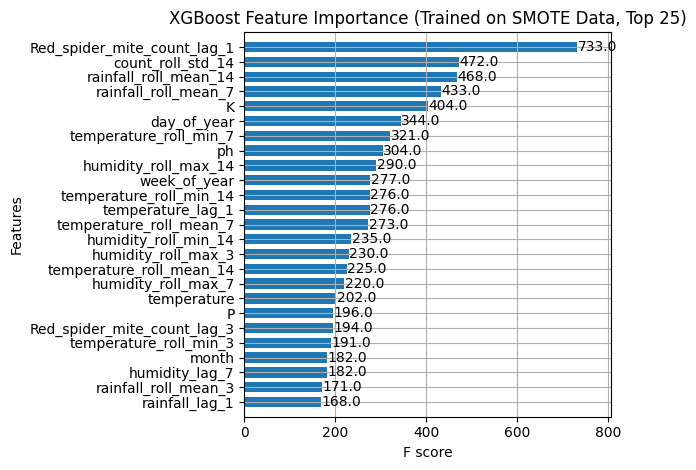


--- Validation Set Performance (Model trained on SMOTE data) ---

Unique True Labels in ORIGINAL Validation Set (y_val_raw): ['Low' 'Severe' 'High' 'Medium']
Unique Predicted Labels in ORIGINAL Validation Set (y_pred_val_labels): ['High' 'Low' 'Medium' 'Severe']
Accuracy: 0.9975

Classification Report (Validation Set):
              precision    recall  f1-score   support

        High       0.90      0.90      0.90        10
         Low       1.00      1.00      1.00      1816
      Medium       0.83      0.77      0.80        13
      Severe       1.00      1.00      1.00       160

    accuracy                           1.00      1999
   macro avg       0.93      0.92      0.92      1999
weighted avg       1.00      1.00      1.00      1999


Confusion Matrix (Validation Set):


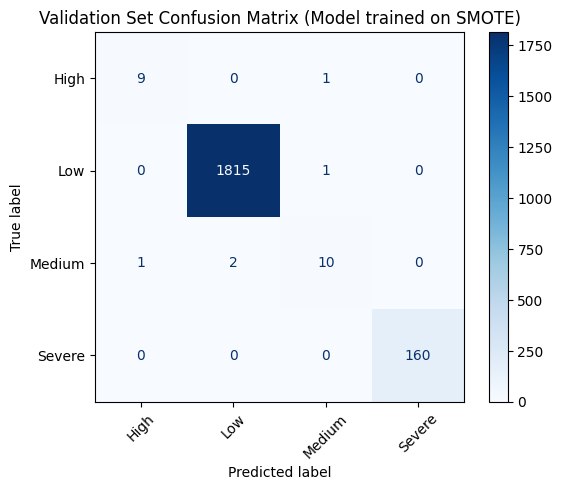


Model trained. Ready to evaluate on the unseen Test Set.

--- Test Set Performance (Model trained on SMOTE data) ---

Unique True Labels in ORIGINAL Test Set (y_test_raw): ['Low' 'Severe' 'High' 'Medium']
Unique Predicted Labels in ORIGINAL Test Set (y_pred_test_labels): ['High' 'Low' 'Medium' 'Severe']
Accuracy: 0.9970

Classification Report (Test Set):
              precision    recall  f1-score   support

        High       0.82      0.82      0.82        11
         Low       1.00      1.00      1.00      1815
      Medium       0.83      0.77      0.80        13
      Severe       0.99      1.00      1.00       160

    accuracy                           1.00      1999
   macro avg       0.91      0.90      0.90      1999
weighted avg       1.00      1.00      1.00      1999


Confusion Matrix (Test Set):


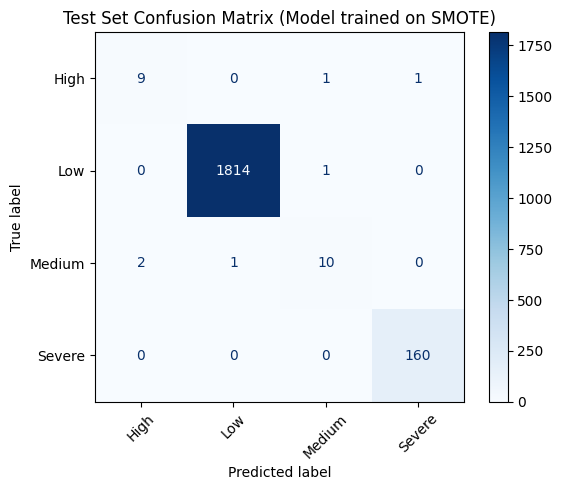

In [21]:
# Continue from the previous script where 'final_df' was created

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # We'll use this carefully
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import xgboost as xgb
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Ensure final_df is available and sorted
final_df = final_df.sort_index()

print("\nStarting Model Training Steps...")
print("Final DataFrame shape:", final_df.shape)
print("Target Categories Distribution:")
print(final_df['Red_spider_mite_category'].value_counts())

# --- Step 3: Data Splitting (Stratified) & Preparation ---

# Target Variable: Category
TARGET = 'Red_spider_mite_category'

# Features: All except target, original count, and label
features_to_drop = [TARGET, 'Red_spider_mite_count', 'label']
FEATURES = [col for col in final_df.columns if col not in features_to_drop]

X = final_df[FEATURES]
y_raw = final_df[TARGET]

print(f"\nTarget variable: {TARGET}")
print(f"Number of features: {len(FEATURES)}")

# Encode the Target Variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
class_names = list(label_encoder.classes_) # Get ordered list of class names
print("\nTarget Class Encoding:")
print(class_mapping)
num_classes = len(class_mapping)

# --- Stratified Splitting ---
# Split into Train (60%) and Temp (40%)
print("\nSplitting data using Stratified Shuffle Split (60% Train / 40% Temp)...")
X_train_temp, X_temp, y_train_temp, y_temp_raw = train_test_split(
    X, y_raw, test_size=0.4, random_state=42, stratify=y_raw # Stratify here
)

# Split Temp (40%) into Validation (20%) and Test (20%)
print("Splitting Temp into Validation (50% of Temp -> 20% of Total) and Test (50% of Temp -> 20% of Total)...")
X_val, X_test, y_val_raw, y_test_raw = train_test_split(
    X_temp, y_temp_raw, test_size=0.5, random_state=42, stratify=y_temp_raw # Stratify again
)

# Encode the split labels
y_train = label_encoder.transform(y_train_temp) # Use the already fitted encoder
y_val = label_encoder.transform(y_val_raw)
y_test = label_encoder.transform(y_test_raw)

# Assign X_train from the initial split
X_train = X_train_temp

print("\nStratified Data Split Sizes:")
print(f"Train:      X={X_train.shape}, y={y_train.shape}")
print(f"Validation: X={X_val.shape},   y={y_val.shape}")
print(f"Test:       X={X_test.shape},    y={y_test.shape}")

# --- Add this check right after splitting ---
print("\nChecking diversity in the NEW Validation Set (y_val_raw):")
print(y_val_raw.value_counts()) # <<< Should show multiple categories now
print("\nChecking diversity in the NEW Test Set (y_test_raw):")
print(y_test_raw.value_counts()) # <<< Should show multiple categories now

# --- Feature Scaling --- (Fit ONLY on X_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Convert back to DataFrames (optional but maintains index/columns)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=FEATURES)
X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index, columns=FEATURES)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=FEATURES)
print("\nFeature scaling complete.")

# --- Step 4: Model Training (XGBoost Classifier) ---

# Address Class Imbalance: Calculate scale_pos_weight for binary or weights for multi-class
# For multi-class XGBoost, manually calculate weights: inverse of frequency

# --- Re-Check Split Diversity (as before, confirm val is still skewed) ---
print("\n--- Confirming Pre-Sampling Split Diversity ---")
print("\nOriginal Validation Set (y_val_raw):")
print(y_val_raw.value_counts()) # Expected to be mostly/all 'Low'
print("\nOriginal Test Set (y_test_raw):")
print(y_test_raw.value_counts()) # Check if test set has more diversity

# --- Step 3.5: Apply SMOTE to the Training Data Only ---

print("\nApplying SMOTE to the training data...")
# Note: Apply SMOTE *after* scaling if the algorithm is distance-based (like KNN used within SMOTE)
# It's generally safer to apply SMOTE to the scaled data.
smote = SMOTE(random_state=42, k_neighbors=3) # k_neighbors must be <= smallest class count - 1 in training set before SMOTE

# Check minority class counts in y_train before applying SMOTE
unique, counts = np.unique(y_train, return_counts=True)
minority_counts = dict(zip(unique, counts))
print(f"Class distribution in y_train BEFORE SMOTE: {minority_counts}")

# Adjust k_neighbors if necessary based on the smallest class count
min_class_count = min(counts) if len(counts) > 0 else 0
if min_class_count <= smote.k_neighbors:
    new_k = max(1, min_class_count - 1) # k must be at least 1
    print(f"Warning: Smallest class count ({min_class_count}) is <= k_neighbors ({smote.k_neighbors}). Adjusting k_neighbors to {new_k}.")
    smote.k_neighbors = new_k

if min_class_count > 1: # SMOTE requires at least 2 samples in the smallest class
    try:
        X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

        print("SMOTE resampling complete.")
        print("Shape of X_train after SMOTE:", X_train_smote.shape)
        print("Shape of y_train after SMOTE:", y_train_smote.shape)

        # Check class distribution AFTER SMOTE
        unique_smote, counts_smote = np.unique(y_train_smote, return_counts=True)
        print("Class distribution in y_train AFTER SMOTE:")
        print(dict(zip(label_encoder.inverse_transform(unique_smote), counts_smote)))

    except ValueError as e:
        print(f"Error during SMOTE: {e}")
        print("Proceeding without SMOTE due to insufficient samples in a minority class.")
        # Fallback: use original training data
        X_train_smote, y_train_smote = X_train_scaled.copy(), y_train.copy() # Use original if SMOTE fails
else:
     print("Skipping SMOTE: The smallest class in the training set has only 1 sample.")
     X_train_smote, y_train_smote = X_train_scaled.copy(), y_train.copy() # Use original if SMOTE cannot run


# --- Step 4: Model Training (XGBoost Classifier) - TRAIN ON SMOTE DATA ---

num_classes = len(np.unique(y_train_smote)) # Update num_classes based on resampled data if needed

xgb_clf_smote = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes, # Use the number of classes PRESENT in y_train_smote
    eval_metric='mlogloss',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
    # No scale_pos_weight needed now as SMOTE handled imbalance
)

print("\nTraining XGBoost Classifier model on SMOTE data...")

# Train the model using the RESAMPLED training data
# Evaluate using the ORIGINAL validation data
xgb_clf_smote.fit(
    X_train_smote, y_train_smote, # <--- Use SMOTE data for training
    eval_set=[(X_val_scaled, y_val)], # <--- Use ORIGINAL validation data for early stopping
    verbose=100
)

print("\nModel training complete.")

# --- Feature Importance (on the model trained with SMOTE) ---
plt.figure(figsize=(10, 10))
xgb.plot_importance(xgb_clf_smote, max_num_features=25, height=0.7)
plt.title('XGBoost Feature Importance (Trained on SMOTE Data, Top 25)')
plt.tight_layout()
plt.show()

# --- Evaluation on ORIGINAL Validation Set ---
print(f"\n--- Validation Set Performance (Model trained on SMOTE data) ---")
# Predict probabilities
y_pred_proba_val = xgb_clf_smote.predict_proba(X_val_scaled)
# Get predicted class index
y_pred_val_encoded = np.argmax(y_pred_proba_val, axis=1)
# Convert back to labels
y_pred_val_labels = label_encoder.inverse_transform(y_pred_val_encoded)

# --- Verification prints ---
print("\nUnique True Labels in ORIGINAL Validation Set (y_val_raw):", y_val_raw.unique())
print("Unique Predicted Labels in ORIGINAL Validation Set (y_pred_val_labels):", np.unique(y_pred_val_labels))

# Calculate metrics
accuracy_val = accuracy_score(y_val, y_pred_val_encoded)
print(f"Accuracy: {accuracy_val:.4f}") # Accuracy might drop from 1.0, which is expected and good!

# Detailed Classification Report
print("\nClassification Report (Validation Set):")
report_val = classification_report(
    y_val_raw,
    y_pred_val_labels,
    labels=class_names, # Ensure all original classes are listed
    target_names=class_names,
    zero_division=0
)
print(report_val)

# Confusion Matrix
print("\nConfusion Matrix (Validation Set):")
cm_val = confusion_matrix(y_val_raw, y_pred_val_labels, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Validation Set Confusion Matrix (Model trained on SMOTE)')
plt.xticks(rotation=45)
plt.show()

# --- Ready for Final Test Set Evaluation ---
print("\nModel trained. Ready to evaluate on the unseen Test Set.")
# --- Evaluation on ORIGINAL Test Set ---
print(f"\n--- Test Set Performance (Model trained on SMOTE data) ---")
# Predict probabilities
y_pred_proba_test = xgb_clf_smote.predict_proba(X_test_scaled)
# Get predicted class index
y_pred_test_encoded = np.argmax(y_pred_proba_test, axis=1)
# Convert back to labels
y_pred_test_labels = label_encoder.inverse_transform(y_pred_test_encoded)

# --- Verification prints ---
print("\nUnique True Labels in ORIGINAL Test Set (y_test_raw):", y_test_raw.unique())
print("Unique Predicted Labels in ORIGINAL Test Set (y_pred_test_labels):", np.unique(y_pred_test_labels))

# Calculate metrics
accuracy_test = accuracy_score(y_test, y_pred_test_encoded)
print(f"Accuracy: {accuracy_test:.4f}")

# Detailed Classification Report
print("\nClassification Report (Test Set):")
report_test = classification_report(
    y_test_raw,
    y_pred_test_labels,
    labels=class_names, # Ensure all original classes are listed
    target_names=class_names,
    zero_division=0
)
print(report_test)

print("\nConfusion Matrix (Test Set):")
cm_test = confusion_matrix(y_test_raw, y_pred_test_labels, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Test Set Confusion Matrix (Model trained on SMOTE)')
plt.xticks(rotation=45)
plt.show()


--- Generating Synthetic Test Data ---
Generating 250 synthetic samples per category (1000 total).
Generating data for category: High
Generating data for category: Low
Generating data for category: Medium
Generating data for category: Severe

Synthetic Data Generated: X shape=(1000, 56), y shape=1000
Distribution of generated synthetic 'true' labels:
High      250
Low       250
Medium    250
Severe    250
Name: count, dtype: int64

--- Testing Model on Synthetic Data ---
Predicting on synthetic data...

--- Evaluation on Synthetic Data ---
Accuracy on Synthetic Data: 0.2460

Classification Report (Synthetic Data):
              precision    recall  f1-score   support

        High       1.00      0.00      0.01       250
         Low       0.25      0.88      0.38       250
      Medium       0.00      0.00      0.00       250
      Severe       0.24      0.10      0.15       250

    accuracy                           0.25      1000
   macro avg       0.37      0.25      0.13      10

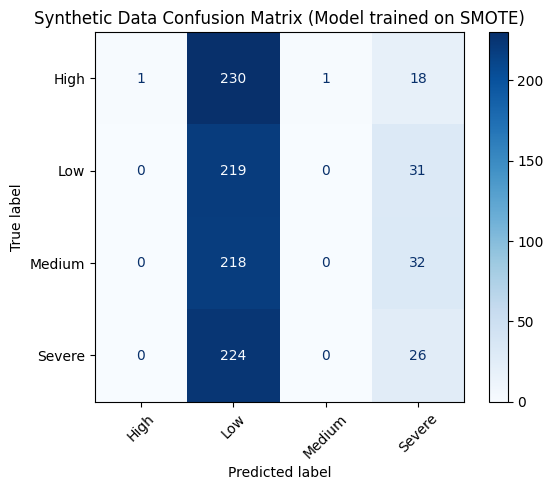


Synthetic data testing complete.


In [12]:
# --- Step 5: Generate Synthetic Data for Testing ---
print("\n--- Generating Synthetic Test Data ---")

# Configuration
n_synthetic_samples_per_category = 250 # Generate this many samples for each category
n_synthetic_total = n_synthetic_samples_per_category * num_classes # num_classes derived earlier
print(f"Generating {n_synthetic_samples_per_category} synthetic samples per category ({n_synthetic_total} total).")

synthetic_X_list = []
synthetic_y_true_list = []

# Use the original unscaled training data (X_train) as the basis for sampling
# This captures the typical range and distribution of values seen during training
source_data_for_sampling = X_train

for i, category_name in enumerate(class_names):
    print(f"Generating data for category: {category_name}")
    # Create a dictionary to hold synthetic features for this category
    synthetic_data_dict = {}
    for feature in FEATURES:
        # Sample with replacement from the observed values in the original training set for this feature
        synthetic_data_dict[feature] = np.random.choice(
            source_data_for_sampling[feature],
            size=n_synthetic_samples_per_category,
            replace=True
        )

    # Convert the dictionary to a DataFrame
    category_df = pd.DataFrame(synthetic_data_dict)
    synthetic_X_list.append(category_df)

    # Create the corresponding true labels for this synthetic batch
    synthetic_y_true_list.extend([category_name] * n_synthetic_samples_per_category)

# Combine all synthetic data
synthetic_X = pd.concat(synthetic_X_list, ignore_index=True)
synthetic_y_true_labels = pd.Series(synthetic_y_true_list) # These are the 'ground truth' labels we assigned

print(f"\nSynthetic Data Generated: X shape={synthetic_X.shape}, y shape={len(synthetic_y_true_labels)}")
print("Distribution of generated synthetic 'true' labels:")
print(synthetic_y_true_labels.value_counts())



--- Generating Synthetic Test Data (Improved Method: Row Sampling) ---
Generating 250 synthetic samples per category (1000 total).
Generating data for category: High
Generating data for category: Low
Generating data for category: Medium
Generating data for category: Severe

Synthetic Data Generated: X shape=(1000, 56), y shape=1000
Distribution of generated synthetic 'true' labels:
High      250
Low       250
Medium    250
Severe    250
Name: count, dtype: int64

--- Testing Model on Synthetic Data ---
Predicting on synthetic data...

--- Evaluation on Synthetic Data ---
Accuracy on Synthetic Data: 1.0000

Classification Report (Synthetic Data):
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       250
         Low       1.00      1.00      1.00       250
      Medium       1.00      1.00      1.00       250
      Severe       1.00      1.00      1.00       250

    accuracy                           1.00      1000
   macro avg       

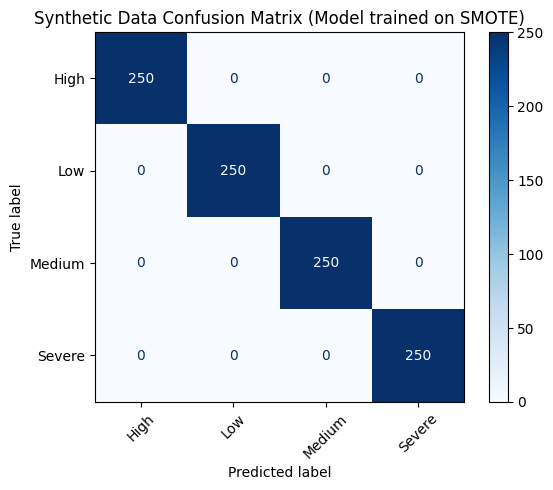


Synthetic data testing complete.


In [22]:
# --- Step 5: Generate Synthetic Data for Testing (IMPROVED METHOD) ---
print("\n--- Generating Synthetic Test Data (Improved Method: Row Sampling) ---")

# Configuration
n_synthetic_samples_per_category = 250 # Generate this many samples for each category
n_synthetic_total = n_synthetic_samples_per_category * num_classes
print(f"Generating {n_synthetic_samples_per_category} synthetic samples per category ({n_synthetic_total} total).")

synthetic_X_list = []
synthetic_y_true_list = []

# Use the original unscaled training data (X_train) and its raw labels (y_train_raw - create this if needed)
# Make sure y_train_raw corresponds to X_train BEFORE scaling/SMOTE
# If you followed the stratified split code exactly, y_train_temp is the raw label series for X_train
y_train_raw_for_sampling = y_train_temp # Or recreate it if necessary: y_train_raw_for_sampling = final_df.loc[X_train.index, TARGET]

for i, category_name in enumerate(class_names):
    print(f"Generating data for category: {category_name}")

    # Find the indices in the original training set belonging to this category
    category_indices = X_train[y_train_raw_for_sampling == category_name].index

    if len(category_indices) == 0:
        print(f"Warning: No samples found for category '{category_name}' in the source training data. Skipping.")
        continue

    # Sample WITH REPLACEMENT from these specific rows (preserves feature correlations within rows)
    sampled_indices = np.random.choice(category_indices, size=n_synthetic_samples_per_category, replace=True)

    # Get the corresponding feature vectors from X_train
    category_df = X_train.loc[sampled_indices].copy() # Use .loc to get rows by index label
    synthetic_X_list.append(category_df)

    # Create the corresponding true labels
    synthetic_y_true_list.extend([category_name] * n_synthetic_samples_per_category)

# Combine all synthetic data
if synthetic_X_list: # Check if any data was actually generated
    synthetic_X = pd.concat(synthetic_X_list, ignore_index=True) # ignore_index is fine here as we don't need original index
    synthetic_y_true_labels = pd.Series(synthetic_y_true_list)

    print(f"\nSynthetic Data Generated: X shape={synthetic_X.shape}, y shape={len(synthetic_y_true_labels)}")
    print("Distribution of generated synthetic 'true' labels:")
    print(synthetic_y_true_labels.value_counts())

    # --- Step 6 & 7: Prepare, Test, and Evaluate Synthetic Data (Code remains the same) ---
    # ... Scale synthetic_X using the existing scaler ...
    # ... Predict using xgb_clf_smote ...
    # ... Evaluate performance ...

    # --- Step 6: Prepare and Test Synthetic Data ---

    print("\n--- Testing Model on Synthetic Data ---")

    # 1. Scale the synthetic features using the SAME scaler fitted on the original training data
    synthetic_X_scaled = scaler.transform(synthetic_X)
    # Optional: Convert back to DataFrame (helps if you want to inspect)
    synthetic_X_scaled_df = pd.DataFrame(synthetic_X_scaled, columns=FEATURES)

    # 2. Encode the synthetic 'true' labels (so we can compare with model's numeric output)
    synthetic_y_true_encoded = label_encoder.transform(synthetic_y_true_labels)

    # 3. Predict using the trained model (xgb_clf_smote)
    print("Predicting on synthetic data...")
    synthetic_y_pred_proba = xgb_clf_smote.predict_proba(synthetic_X_scaled)
    synthetic_y_pred_encoded = np.argmax(synthetic_y_pred_proba, axis=1)

    # 4. Decode the predictions back to category names
    synthetic_y_pred_labels = label_encoder.inverse_transform(synthetic_y_pred_encoded)

    # --- Step 7: Evaluate Performance on Synthetic Data ---

    print("\n--- Evaluation on Synthetic Data ---")

    # Calculate Accuracy
    accuracy_synthetic = accuracy_score(synthetic_y_true_encoded, synthetic_y_pred_encoded)
    print(f"Accuracy on Synthetic Data: {accuracy_synthetic:.4f}")

    # Classification Report
    # Compare the 'true' labels we assigned (synthetic_y_true_labels)
    # with the model's predictions (synthetic_y_pred_labels)
    print("\nClassification Report (Synthetic Data):")
    report_synthetic = classification_report(
        synthetic_y_true_labels, # Original string labels
        synthetic_y_pred_labels, # Predicted string labels
        labels=class_names,      # Ensure all classes are included
        target_names=class_names,
        zero_division=0
    )
    print(report_synthetic)

    # Confusion Matrix
    print("\nConfusion Matrix (Synthetic Data):")
    cm_synthetic = confusion_matrix(
        synthetic_y_true_labels, # Original string labels
        synthetic_y_pred_labels, # Predicted string labels
        labels=class_names       # Order the matrix by class names
    )
    disp_synthetic = ConfusionMatrixDisplay(confusion_matrix=cm_synthetic, display_labels=class_names)
    disp_synthetic.plot(cmap=plt.cm.Blues)
    plt.title('Synthetic Data Confusion Matrix (Model trained on SMOTE)')
    plt.xticks(rotation=45)
    plt.show()

    print("\nSynthetic data testing complete.")

else:
    print("\nNo synthetic data could be generated (perhaps missing categories in source data?). Skipping synthetic evaluation.")

In [23]:
import joblib
import pandas as pd
import os

# --- Assuming these variables exist after training ---
# xgb_clf_smote (your trained model)
# scaler (your fitted StandardScaler)
# label_encoder (your fitted LabelEncoder)
# FEATURES (list of feature column names used for training)
# final_df (your final dataframe before splitting)
# ----------------------------------------------------

ARTIFACTS_DIR = 'dashboard_artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Save the model
joblib.dump(xgb_clf_smote, os.path.join(ARTIFACTS_DIR, 'xgb_model.joblib'))
print("Model saved.")

# Save the scaler
joblib.dump(scaler, os.path.join(ARTIFACTS_DIR, 'scaler.joblib'))
print("Scaler saved.")

# Save the label encoder
joblib.dump(label_encoder, os.path.join(ARTIFACTS_DIR, 'label_encoder.joblib'))
print("Label Encoder saved.")

# Save the feature list
joblib.dump(FEATURES, os.path.join(ARTIFACTS_DIR, 'features.joblib'))
print("Feature list saved.")

# Save recent history (e.g., last 30 days) from final_df
# Ensure final_df has the DatetimeIndex
if isinstance(final_df.index, pd.DatetimeIndex):
    recent_history = final_df.iloc[-30:].copy() # Save last 30 days
    recent_history.to_csv(os.path.join(ARTIFACTS_DIR, 'recent_history.csv'))
    print("Recent history saved.")
else:
    print("Warning: final_df does not have a DatetimeIndex. Cannot save history correctly by date.")
    # Optional: Save last N rows by position if index isn't datetime
    # final_df.iloc[-30:].to_csv(os.path.join(ARTIFACTS_DIR, 'recent_history.csv'))


print(f"All artifacts saved to '{ARTIFACTS_DIR}' directory.")

Model saved.
Scaler saved.
Label Encoder saved.
Feature list saved.
Recent history saved.
All artifacts saved to 'dashboard_artifacts' directory.


In [ ]:
import pandas as pd
import numpy as np
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
import datetime
from PIL import Image
import base64
from io import BytesIO

# Load model and scaler
# Note: In a real application, you would load these files
# model = joblib.load('/content/best_mite_prediction_model.pkl')
# scaler = joblib.load('scaler.pkl')

def load_sample_data():
    """Load sample data for demonstration"""
    # This would be replaced with real-time sensor data in production
    data = pd.DataFrame({
        'timestamp': pd.date_range(start='2023-01-01', periods=30, freq='D'),
        'temperature': np.random.uniform(20, 35, 30),
        'humidity': np.random.uniform(60, 95, 30),
        'rainfall': np.random.uniform(5, 200, 30),
        'ph': np.random.uniform(5.5, 7.5, 30),
        'N': np.random.uniform(10, 120, 30),
        'P': np.random.uniform(10, 120, 30),
        'K': np.random.uniform(10, 120, 30),
        'red_spider_count': np.random.randint(80, 180, 30)
    })

    # Add predicted risk level (in real app this would come from the model)
    data['risk_level'] = data['red_spider_count'].apply(
        lambda x: 'Low' if x < 110 else 'Medium' if x < 150 else 'High'
    )

    # Add confidence score (simulated)
    data['confidence'] = np.random.uniform(0.7, 0.95, 30)

    return data

def create_risk_gauge(current_risk, confidence):
    """Create a risk gauge visualization"""
    risk_map = {'Low': 1, 'Medium': 2, 'High': 3}
    risk_value = risk_map.get(current_risk, 0)

    fig = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=risk_value,
        domain={'x': [0, 1], 'y': [0, 1]},
        title={'text': f"Current Risk Level: {current_risk}"},
        gauge={
            'axis': {'range': [0, 3], 'tickvals': [1, 2, 3], 'ticktext': ["Low", "Medium", "High"]},
            'bar': {'color': "darkblue"},
            'steps': [
                {'range': [0, 1], 'color': "lightgreen"},
                {'range': [1, 2], 'color': "gold"},
                {'range': [2, 3], 'color': "salmon"}
            ],
            'threshold': {
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': risk_value
            }
        }
    ))

    fig.add_annotation(
        x=0.5, y=0.25,
        text=f"Confidence: {confidence:.1%}",
        showarrow=False
    )

    return fig

def plot_environmental_factors(data):
    """Plot key environmental factors over time"""
    # Create subplots
    fig = make_subplots(rows=3, cols=1,
                        subplot_titles=("Temperature & Humidity", "Rainfall", "Soil Nutrients"),
                        shared_xaxes=True,
                        vertical_spacing=0.1)

    # Temperature and humidity
    fig.add_trace(
        go.Scatter(x=data['timestamp'], y=data['temperature'], name="Temperature (°C)"),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=data['timestamp'], y=data['humidity'], name="Humidity (%)", line=dict(dash='dot')),
        row=1, col=1
    )

    # Rainfall
    fig.add_trace(
        go.Bar(x=data['timestamp'], y=data['rainfall'], name="Rainfall (mm)"),
        row=2, col=1
    )

    # Soil nutrients
    fig.add_trace(
        go.Scatter(x=data['timestamp'], y=data['N'], name="Nitrogen (N)"),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(x=data['timestamp'], y=data['P'], name="Phosphorus (P)"),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(x=data['timestamp'], y=data['K'], name="Potassium (K)"),
        row=3, col=1
    )

    # Add threshold for ideal temperature range for mites
    fig.add_hline(y=30, line_dash="dash", line_color="red", annotation_text="Mite Favorable Temp", row=1, col=1)

    # Add favorable humidity threshold
    fig.add_hline(y=80, line_dash="dash", line_color="red", annotation_text="Mite Favorable Humidity", row=1, col=1)

    # Update layout
    fig.update_layout(height=700, title_text="Key Environmental Factors")

    return fig

def plot_risk_timeline(data):
    """Plot risk level over time"""
    risk_map = {'Low': 1, 'Medium': 2, 'High': 3}
    data['risk_numeric'] = data['risk_level'].map(risk_map)

    fig = px.line(data, x='timestamp', y='risk_numeric',
                 labels={'risk_numeric': 'Risk Level', 'timestamp': 'Date'},
                 title='Risk Level Trend')

    fig.update_layout(
        yaxis = dict(
            tickmode = 'array',
            tickvals = [1, 2, 3],
            ticktext = ['Low', 'Medium', 'High']
        )
    )

    # Color regions by risk level
    fig.add_hrect(y0=0, y1=1.5, fillcolor="green", opacity=0.1, line_width=0)
    fig.add_hrect(y0=1.5, y1=2.5, fillcolor="yellow", opacity=0.1, line_width=0)
    fig.add_hrect(y0=2.5, y1=3.5, fillcolor="red", opacity=0.1, line_width=0)

    return fig

def plot_mite_heatmap(data):
    """Create a heatmap of predicted mite risk over time"""
    # For demonstration, we'll create a 2D grid representing field sections
    # In a real app, this would use GPS coordinates and actual field sections

    # Create a 5x5 grid
    n_rows, n_cols = 5, 5
    grid_data = []

    # Get the most recent risk level
    latest_risk = data.iloc[-1]['risk_level']
    risk_seed = {'Low': 0.2, 'Medium': 0.5, 'High': 0.8}[latest_risk]

    # Generate random risk values for each grid cell with spatial correlation
    for i in range(n_rows):
        for j in range(n_cols):
            # Create spatial pattern - higher risk in center, lower at edges
            distance_from_center = np.sqrt((i - n_rows/2)**2 + (j - n_cols/2)**2)
            max_distance = np.sqrt((n_rows/2)**2 + (n_cols/2)**2)

            # Normalize distance and invert (center has highest risk)
            normalized_distance = 1 - (distance_from_center / max_distance)

            # Calculate risk value
            risk_value = risk_seed * normalized_distance + np.random.normal(0, 0.1)
            risk_value = max(0, min(1, risk_value))  # Clip to [0,1]

            grid_data.append({'row': i, 'col': j, 'risk': risk_value})

    # Convert to dataframe
    grid_df = pd.DataFrame(grid_data)

    # Create heatmap
    fig = px.imshow(
        grid_df.pivot(index='row', columns='col', values='risk'),
        color_continuous_scale='RdYlGn_r',
        labels=dict(color="Risk Index"),
        title="Field Risk Map (Latest)",
        aspect="equal"
    )

    # Add field section labels
    fig.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = list(range(n_cols)),
            ticktext = [f'S{i+1}' for i in range(n_cols)]
        ),
        yaxis = dict(
            tickmode = 'array',
            tickvals = list(range(n_rows)),
            ticktext = [f'R{i+1}' for i in range(n_rows)]
        )
    )

    return fig

def create_action_recommendations(risk_level):
    """Generate action recommendations based on risk level"""
    recommendations = {
        'Low': [
            "Continue regular monitoring (weekly inspections)",
            "Maintain beneficial predators (ladybugs, lacewings)",
            "Ensure proper irrigation to prevent water stress",
            "Document observations for future reference"
        ],
        'Medium': [
            "Increase monitoring frequency to every 3 days",
            "Release additional predatory mites as preventive control",
            "Check undersides of leaves for early colonies",
            "Prepare spray equipment and biological controls",
            "Avoid unnecessary nitrogen fertilization which promotes mite population growth"
        ],
        'High': [
            "URGENT: Implement control measures immediately",
            "Apply approved miticides or biological controls",
            "Focus on hotspots identified in field risk map",
            "Consider spot treatments rather than whole-field application",
            "Monitor effectiveness after 2-3 days",
            "Alert neighboring farms of potential spread risk"
        ]
    }

    return recommendations.get(risk_level, [])

def plot_contributing_factors(data):
    """Create a visualization of factors contributing to current risk level"""
    # In a real application, this would use feature importances from the model
    # For demo, we'll simulate feature importance

    latest_row = data.iloc[-1]
    factors = {
        'Temperature': min(1, latest_row['temperature'] / 35),
        'Humidity': min(1, latest_row['humidity'] / 90),
        'Rainfall (inverse)': 1 - min(1, latest_row['rainfall'] / 200),
        'N Content': min(1, latest_row['N'] / 120),
        'Previous Infestation': np.random.uniform(0.3, 0.9)
    }

    # Normalize factors
    total = sum(factors.values())
    normalized_factors = {k: v/total for k, v in factors.items()}

    # Create figure
    fig = go.Figure(go.Bar(
        x=list(normalized_factors.values()),
        y=list(normalized_factors.keys()),
        orientation='h'
    ))

    fig.update_layout(
        title="Factors Contributing to Current Risk Level",
        xaxis_title="Relative Importance",
        yaxis_title="Factor",
        height=400
    )

    return fig

def display_forecast(data):
    """Display a 7-day forecast of mite risk"""
    # In a real app, this would use the model to predict future risk
    # For demo, we'll generate some random forecasts

    # Get current risk level
    current_risk = data.iloc[-1]['risk_level']
    risk_levels = ['Low', 'Medium', 'High']
    current_idx = risk_levels.index(current_risk)

    # Generate forecast (biased toward current state but with some movement)
    forecast = []
    for i in range(7):
        # Higher chance of staying the same or moving one level
        if i < 3:
            # First 3 days more stable
            weights = [0.7, 0.2, 0.1] if current_idx == 0 else \
                     [0.2, 0.7, 0.1] if current_idx == 1 else \
                     [0.1, 0.2, 0.7]
        else:
            # Later days more variable
            weights = [0.5, 0.3, 0.2] if current_idx == 0 else \
                     [0.3, 0.5, 0.2] if current_idx == 1 else \
                     [0.2, 0.3, 0.5]

        # Shift weights according to current risk level
        if current_idx == 0:
            pass  # Low risk - weights stay as is
        elif current_idx == 1:
            weights = [weights[2], weights[0], weights[1]]  # Medium risk - shift
        else:
            weights = [weights[1], weights[2], weights[0]]  # High risk - shift

        forecast_level = np.random.choice(risk_levels, p=weights)
        confidence = np.random.uniform(0.6, 0.9)
        forecast.append((forecast_level, confidence))

    return forecast

def main():
    st.set_page_config(
        page_title="Red Spider Mite Early Warning System",
        page_icon="🕷️",
        layout="wide"
    )

    # Load sample data
    data = load_sample_data()

    # Header
    st.title("🕷️ Red Spider Mite Early Warning System")
    st.markdown("### Real-time monitoring and predictive analytics for pest management")

    # Date selector (in a real app, this would change the data displayed)
    today = datetime.datetime.now().date()
    st.sidebar.date_input("Select Date", today)

    # Add farm selector
    st.sidebar.selectbox("Select Farm", ["Main Farm", "North Field", "South Field"])

    # Add crop selector
    st.sidebar.selectbox("Select Crop", ["Rice", "Cotton", "Soybean", "Corn"])

    # Current conditions section
    st.sidebar.markdown("### Current Conditions")
    latest = data.iloc[-1]
    st.sidebar.metric("Temperature", f"{latest['temperature']:.1f} °C")
    st.sidebar.metric("Humidity", f"{latest['humidity']:.1f} %")
    st.sidebar.metric("Rainfall (24h)", f"{latest['rainfall']:.1f} mm")

    # Main dashboard layout
    col1, col2 = st.columns([2, 1])

    # Risk gauge in first column
    with col1:
        current_risk = data.iloc[-1]['risk_level']
        confidence = data.iloc[-1]['confidence']
        st.plotly_chart(create_risk_gauge(current_risk, confidence), use_container_width=True)

    # Action recommendations in second column
    with col2:
        st.markdown("### Recommended Actions")
        for action in create_action_recommendations(current_risk):
            st.markdown(f"- {action}")

    # Risk forecast
    st.markdown("### 7-Day Risk Forecast")
    forecast = display_forecast(data)

    forecast_cols = st.columns(7)
    for i, (day, (risk, conf)) in enumerate(zip(range(1, 8), forecast)):
        with forecast_cols[i]:
            day_name = (datetime.datetime.now() + datetime.timedelta(days=i)).strftime("%a")
            st.markdown(f"**{day_name}**")
            color = "green" if risk == "Low" else "orange" if risk == "Medium" else "red"
            st.markdown(f"<div style='padding:10px;border-radius:5px;background-color:{color};color:white;text-align:center;'>{risk}<br>{conf:.0%}</div>", unsafe_allow_html=True)

    # Tabs for different visualizations
    tab1, tab2, tab3, tab4 = st.tabs(["Environmental Factors", "Risk Timeline", "Field Map", "Contributing Factors"])

    with tab1:
        st.plotly_chart(plot_environmental_factors(data), use_container_width=True)

    with tab2:
        st.plotly_chart(plot_risk_timeline(data), use_container_width=True)

    with tab3:
        st.plotly_chart(plot_mite_heatmap(data), use_container_width=True)

    with tab4:
        st.plotly_chart(plot_contributing_factors(data), use_container_width=True)

    # Notifications and Alerts Section
    st.markdown("### Recent Alerts")
    alert_container = st.container()
    with alert_container:
        if current_risk == "High":
            st.error("⚠️ HIGH RISK ALERT: Red spider mite population predicted to reach economic threshold within 48 hours. Immediate action recommended.")
        elif current_risk == "Medium":
            st.warning("⚠️ MEDIUM RISK ALERT: Environmental conditions favorable for red spider mite development. Increase monitoring frequency.")

        # Historical alerts (simulated)
        st.info("🔔 System detected temperature and humidity in optimal range for mite reproduction (3 days ago)")
        st.info("🔔 Neighboring farm reported mite detection in north field (5 days ago)")

    # Help section in sidebar
    st.sidebar.markdown("---")
    with st.sidebar.expander("About This Dashboard"):
        st.markdown("""
        This early warning system uses machine learning to predict red spider mite outbreaks before they reach damaging levels. The system integrates:

        - Real-time environmental monitoring
        - Historical pest data
        - Predictive analytics
        - Spatiotemporal mapping

        The dashboard provides actionable insights to help farmers implement timely and targeted interventions, reducing pesticide use and crop damage.
        """)

if __name__ == "__main__":
    main()

2025-02-27 20:52:23.744 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 20:52:23.766 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 20:52:24.532 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-27 20:52:24.538 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 20:52:24.546 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 20:52:24.549 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-27 20:52:24.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn